In [237]:
library(tidyverse)
library(tigris)
options(tigris_use_cache = T)
options(repr.plot.height=4, repr.plot.width=10)
theme_set(theme_classic())

# STATS 504
## Week 15: Predicting air quality

### Getting current data

In [46]:
county_fips <- c("
    06001
    08013
    12001
    18105
    25017
    26161
    37063
    41039
    42027
    55025
") %>% str_trim %>% str_split('\\s+', simplify = T) 

county_fips %>% str

 chr [1, 1:10] "06001" "08013" "12001" "18105" "25017" "26161" "37063" ...


In [49]:
state_fips <- county_fips %>% str_sub(1, 2) %>% unique

In [56]:
county_shp <- counties(state = state_fips) %>% mutate(FIPS = paste0(STATEFP, COUNTYFP)) %>% 
    filter(FIPS %in% county_fips)

Retrieving data for the year 2022



In [67]:
(Sys.time() + lubridate::dhours(-1)) %>% format("%Y%m%d%H", tz = "UTC")

[1] "2024120313"

In [115]:
get_data_for <- function(dt) {
    date <-  dt %>% format("%Y%m%d", tz = "UTC")
    hour <- dt %>% format("%H", tz = "UTC")
    base <- "https://s3-us-west-1.amazonaws.com//files.airnowtech.org/airnow/{year}/{date}/HourlyAQObs_{date}{hour}.dat"
    u <- str_glue(base, year=year(dt), date=date, hour=hour)
    fn <- paste0("HourlyAQObs_", date, hour, ".csv")
    if (! file.exists(fn)) { download.file(u, fn) }
    read_csv(fn)
}

In [116]:
aqi <- get_data_for(Sys.time())

Warning message in download.file(u, fn):
“cannot open URL 'https://s3-us-west-1.amazonaws.com//files.airnowtech.org/airnow/2024/20241203/HourlyAQObs_2024120315.dat': HTTP status was '404 Not Found'”


ERROR: Error in download.file(u, fn): cannot open URL 'https://s3-us-west-1.amazonaws.com//files.airnowtech.org/airnow/2024/20241203/HourlyAQObs_2024120315.dat'


In [117]:
aqi <- get_data_for(Sys.time() - dhours(1))

Rows: 4275 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [82]:
library(sf)
aqi_sf <- aqi %>% st_as_sf(coords = c("Longitude", "Latitude"), crs = "WGS84") %>% 
    st_transform(crs = st_crs(county_shp))

In [87]:
st_join(county_shp, aqi_sf) %>% select(FIPS, NAME, ends_with("AQI")) %>%
    st_drop_geometry %>% group_by(FIPS, NAME) %>% 
    summarize(across(ends_with("AQI"), \(v) mean(v, na.rm = T)))

`summarise()` has grouped output by 'FIPS'. You can override using the `.groups` argument.


FIPS,NAME,OZONE_AQI,PM10_AQI,PM25_AQI,NO2_AQI
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
06001,Alameda,7.2,NaN,42.33333,17.4
08013,Boulder,17.0,4,26.00000,NaN
12001,Alachua,7.0,NaN,56.00000,NaN
18105,Monroe,NaN,NaN,53.00000,NaN
25017,Middlesex,13.0,NaN,24.00000,10.0
26161,Washtenaw,16.0,NaN,52.00000,NaN
37063,Durham,23.0,6,22.00000,NaN
41039,Lane,NaN,NaN,44.14286,NaN
42027,Centre,19.5,NaN,37.00000,NaN


## Building a predictor

In [143]:
# download three month's worth of hourly data
start_date <- make_datetime(2020, 01, 01)
dates <- list()
for (d in 0:90) {
    for (h in 0:23) {
        dt <- start_date + ddays(d) + dhours(h)
        dates <- c(dates, list(dt))
    }
}

In [148]:
library(furrr)

plan(multisession, workers = 12)

dates %>% future_map(get_data_for) %>% list_rbind -> aqi_2020q1

Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2951 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2949 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2949 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2949 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2949 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2950 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2950 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2950 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2950 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2950 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2950 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2950 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2950 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2952 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2953 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2955 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2955 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2954 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2955 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2955 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2955 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2956 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2957 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2957 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2957 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2957 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2957 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2957 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2957 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2957 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2957 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2958 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2959 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2959 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2959 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2960 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2962 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2965 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2965 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2965 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2965 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2959 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2961 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2964 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2973 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2973 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2973 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2973 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2973 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2973 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2973 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2973 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2978 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2978 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2978 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2978 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2980 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2982 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2982 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2982 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2982 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2982 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2982 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2982 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2983 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2983 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2983 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2983 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2983 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2983 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2983 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2983 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2983 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2983 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2989 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2989 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2989 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2995 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2995 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2995 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2995 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2995 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2995 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2995 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2995 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2995 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2995 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2993 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2996 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2996 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2996 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2996 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2996 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2998 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2998 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2998 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 2999 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2999 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQ

Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3000 Columns: 34
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): AQSID, SiteName, Status, EPARegion, CountryCode, StateName, Valid...
dbl  (18): Latitude, Longitude, Elevation, GMTOffset, OZONE_AQI, PM10_AQI, P...
time  (1): ValidTime

ℹ Use `sp

In [151]:
save(aqi_2020q1, file="aqi_2020q1.RData")

In [152]:
glimpse(aqi_2020q1)

Rows: 6,481,925
Columns: 34
$ AQSID                       <chr> "NRB000043", "NRB000042", "483951076", "08…
$ SiteName                    <chr> "Spare Unit", "Viwandani", "Franklin Oak G…
$ Status                      <chr> "Active", "Active", "Active", "Active", "A…
$ EPARegion                   <chr> NA, NA, "R6", "R3", NA, "R10", "R10", "R10…
$ Latitude                    <dbl> -1.280000, -1.311220, 31.168889, 40.277800…
$ Longitude                   <dbl> 36.82000, 36.87311, -96.48194, -105.54530,…
$ Elevation                   <dbl> 0.0, 0.0, 136.9, 2744.7, 0.0, 577.4, 611.2…
$ GMTOffset                   <dbl> 3, 3, -6, -7, 3, -8, -8, -8, -5, -5, -5, -…
$ CountryCode                 <chr> NA, NA, "US", "US", NA, "US", "US", "US", …
$ StateName                   <chr> "N/A", "N/A", "TX", "CO", "N/A", "WA", "WA…
$ ValidDate                   <chr> "01/01/20", "01/01/20", "01/01/20", "01/01…
$ ValidTime                   <time> 00:00:00, 00:00:00, 00:00:00, 00:00:00, 0…
$ DataSource

## Continuous prediction in R
There are a huge variety of methods/packages that are available for doing regression in R:

- (Generalized) linear model: `lm()`, `glm()`, `rlm()`
- Random forest: `CART` / `randomforest`
- LASSO: `glmnet` and friends
- ML/neural net: `nnet`, `caret`, `xgboost`
- For time series specifically:
    - `loess`
    - `arima` 
    - `ses` / exponential smoothing
    - `hw` / Holt-Winters

All of these methods have very different interfaces, e.g.:

In [153]:
lm(height ~ weight, data=women) %>% predict

1        2        3        4        5        6        7        8 
58.75712 59.33162 60.19336 61.05511 61.91686 62.77861 63.64035 64.50210 
       9       10       11       12       13       14       15 
65.65110 66.51285 67.66184 68.81084 69.95984 71.39608 72.83233

In [154]:
library(rpart)
rpart(height ~ weight, data=women) %>% predict

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 
65 65 65 65 65 65 65 65 65 65 65 65 65 65 65

In [155]:
library(glmnet)
x <- cbind(rep(1, nrow(women)), women$weight)
cv.glmnet(x, women$height) %>% print

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-7

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = x, y = women$height) 

Measure: Mean-Squared Error 

    Lambda Index Measure      SE Nonzero
min 0.0654    46  0.2436 0.08936       1
1se 0.3179    29  0.3304 0.13170       1


## Framework for prediction
Abstractly, a prediction problem consists of:

- **A task**: classification or regression. 
- **A model**: linear model, LASSO, regression tree, ...
- **An implementation**: `lm()`, `glmnet()`, ...

For example here are three somewhat equivalent ways of doing random forest regression:

In [156]:
randomForest::randomForest(height ~ weight, data=women, mtry=1, ntree=2000, importance=T)


Call:
 randomForest(formula = height ~ weight, data = women, mtry = 1,      ntree = 2000, importance = T) 
               Type of random forest: regression
                     Number of trees: 2000
No. of variables tried at each split: 1

          Mean of squared residuals: 1.193009
                    % Var explained: 93.61

In [14]:
ranger::ranger(height ~ weight, data=women, mtry=1, num.trees=2000, importance='impurity')

Ranger result

Call:
 ranger::ranger(height ~ weight, data = women, mtry = 1, num.trees = 2000,      importance = "impurity") 

Type:                             Regression 
Number of trees:                  2000 
Sample size:                      15 
Number of independent variables:  1 
Mtry:                             1 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       1.202868 
R squared (OOB):                  0.9398566 

In [162]:
library(xgboost)
data <- women %>% mutate(height = as.numeric(height), weight = as.numeric(weight))
X <- as.matrix(data[,"weight", drop = FALSE]) 
y <- data$height
        
# Train the xgboost model
dtrain <- xgb.DMatrix(data = X, label = y)

xgb_model <- xgboost(
  data = dtrain,
  nrounds = 2000,    
  objective = "reg:squarederror", 
  max_depth = 1,        
  eta = 0.3, 
  verbose = 0,
)



## Tidymodels


In [161]:
library(tidymodels)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.5.9000     ✔ rsample      1.2.0     
✔ dials        1.1.0          ✔ tune         1.0.1     
✔ infer        1.0.4          ✔ workflows    1.1.3     
✔ modeldata    1.1.0          ✔ workflowsets 1.0.0     
✔ parsnip      1.0.4          ✔ yardstick    1.3.1     
✔ recipes      1.0.5          

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ Matrix::expand()  masks tidyr::expand()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ purrr::flatten()  masks jsonlite::flatten()
✖ dplyr::lag()      masks stats::lag()
✖ Matrix::pa

## Creating the prediction dataset


In [191]:
aqi_2020q1[1:100000, ] %>% 
  select(AQSID, Latitude, Longitude, ValidDate, ValidTime, ends_with("AQI")) %>% 
  mutate(AQI = pmax(OZONE_AQI, PM10_AQI, PM25_AQI, NO2_AQI, na.rm = T)) %>% 
  mutate(dt = dmy_hms(paste(ValidDate, ValidTime, sep = " "))) %>%
  arrange(AQSID, dt) %>%
  group_by(AQSID) %>%
  mutate(AQI_fut = lead(AQI, 24)) -> aqi.data

## Declaring the recipe
A `recipe()` is a data frame + function specification:

In [198]:
library(recipes)
aqi.rec <- recipe(
    AQI_fut ~ Latitude + Longitude + AQI,
    data=aq_pred
) %>% print



── Recipe ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



In [199]:
summary(aqi.rec)

variable,type,role,source
<chr>,<list>,<chr>,<chr>
Latitude,"double , numeric",predictor,original
Longitude,"double , numeric",predictor,original
AQI,"double , numeric",predictor,original
AQI_fut,"double , numeric",outcome,original


## Declaring the model
Next we have to declare the model. First, we'll start with the most basic, linear regression:

In [200]:
(lr_mod <- linear_reg())

Linear Regression Model Specification (regression)

Computational engine: lm 


Of course, `lm()` is not the only type of linear regression:

In [201]:
show_engines('linear_reg')

engine,mode
<chr>,<chr>
lm,regression
glm,regression
glmnet,regression
stan,regression
spark,regression
keras,regression
brulee,regression


## Workflow
A workflow pairs a model and a recipe:

In [202]:
library(workflows)
aqi.wflow <- 
  workflow() %>% 
  add_model(lr_mod) %>% 
  add_recipe(aqi.rec) %>% print

══ Workflow ═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Linear Regression Model Specification (regression)

Computational engine: lm 



## Fitting the model

In [203]:
fit.lm <- fit(aqi.wflow, data=aqi.data)
fit.lm

══ Workflow [trained] ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)     Latitude    Longitude          AQI  
    30.3641       0.1531       0.2616       0.5284  


The advantage of this approach is that it becomes super easy to try all sorts of [other models](https://parsnip.tidymodels.org/articles/articles/Examples.html).

In [207]:
bt_reg <- # boosted regression trees
    boost_tree(trees = 10) %>% 
    set_mode("regression") %>% 
    set_engine("xgboost")

fit.bt <- workflow() %>% add_model(bt_reg) %>% add_recipe(aqi.rec) %>% fit(data=drop_na(aqi.data))

In [208]:
fit.bt

══ Workflow [trained] ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
##### xgb.Booster
raw: 28.3 Kb 
call:
  xgboost::xgb.train(params = list(eta = 0.3, max_depth = 6, gamma = 0, 
    colsample_bytree = 1, colsample_bynode = 1, min_child_weight = 1, 
    subsample = 1), data = x$data, nrounds = 10, watchlist = x$watchlist, 
    verbose = 0, nthread = 1, objective = "reg:squarede

## Training and test
Next, we will evaluate different models in terms of their prediction error on a held out data set.

In [211]:
aqi.split <- initial_split(aqi.data[complete.cases(aqi.data),])
training(aqi.split) %>% glimpse

Rows: 348
Columns: 12
Groups: AQSID [52]
$ AQSID     <chr> "421010048", "060670010", "421010048", "201950001", "0610100…
$ Latitude  <dbl> 39.99139, 38.56844, 39.99139, 38.77030, 39.13868, 34.94287, …
$ Longitude <dbl> -75.08083, -121.49311, -75.08083, -99.76360, -121.61884, -12…
$ ValidDate <chr> "01/01/20", "01/01/20", "01/01/20", "01/01/20", "01/01/20", …
$ ValidTime <time> 04:00:00, 08:00:00, 00:00:00, 07:00:00, 00:00:00, 08:00:00,…
$ OZONE_AQI <dbl> 19, 5, 15, 19, 12, 12, 26, 10, 27, 22, 21, 27, 21, 28, 21, 3…
$ PM10_AQI  <dbl> 10, 26, 11, 1, 26, 19, 10, 19, 2, 31, 7, 9, 7, 7, 7, 2, 16, …
$ PM25_AQI  <dbl> 28, 73, 31, 5, 66, 26, 25, 38, 7, 29, 16, 26, 14, 23, 18, 3,…
$ NO2_AQI   <dbl> 4, 14, 17, 0, 8, 4, 7, 13, 2, 5, 2, 4, 3, 4, 11, 0, 18, 12, …
$ AQI       <dbl> 28, 73, 31, 19, 66, 26, 26, 38, 27, 31, 21, 27, 21, 28, 21, …
$ dt        <dttm> 2020-01-01 04:00:00, 2020-01-01 08:00:00, 2020-01-01 00:00:…
$ AQI_fut   <dbl> 52, 71, 41, 19, 70, 25, 45, 37, 25, 25, 27, 51, 28, 29, 35, …

Let's train a random forest regression model on the training data:

In [212]:
rf_mod <- 
  rand_forest(trees = 100) %>% 
  set_engine("ranger", num.threads=4) %>% 
  set_mode("regression") %>% print

Random Forest Model Specification (regression)

Main Arguments:
  trees = 100

Engine-Specific Arguments:
  num.threads = 4

Computational engine: ranger 



In [213]:
fit.rf <- workflow() %>% add_model(rf_mod) %>% add_recipe(aqi.rec) %>% fit(training(aqi.split)) %>% print

══ Workflow [trained] ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, num.trees = ~100,      num.threads = ~4, verbose = FALSE, seed = sample.int(10^5,          1)) 

Type:                             Regression 
Number of trees:                  100 
Sample size:                      348 
Number of independent

## Evaluating prediction error

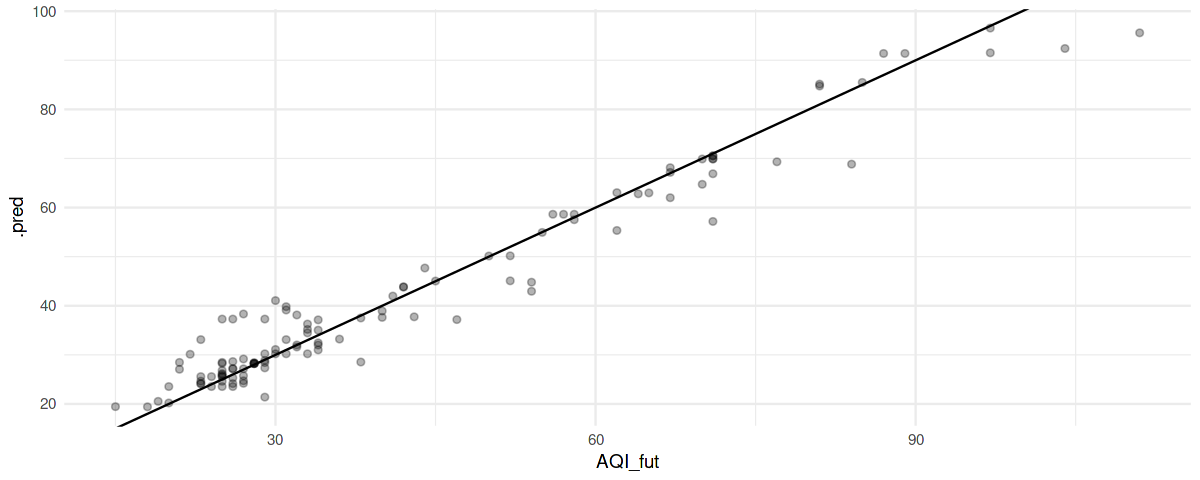

In [236]:
library(modelr)
add_predictions(testing(aqi.split), fit.rf) %>% 
    unnest(cols=c(pred)) %>% 
    ggplot(aes(x=AQI_fut, y=.pred)) + geom_point(alpha=.3) + geom_abline(intercept=0, slope=1)

How good is this prediction? Let's compare to the simple linear model:

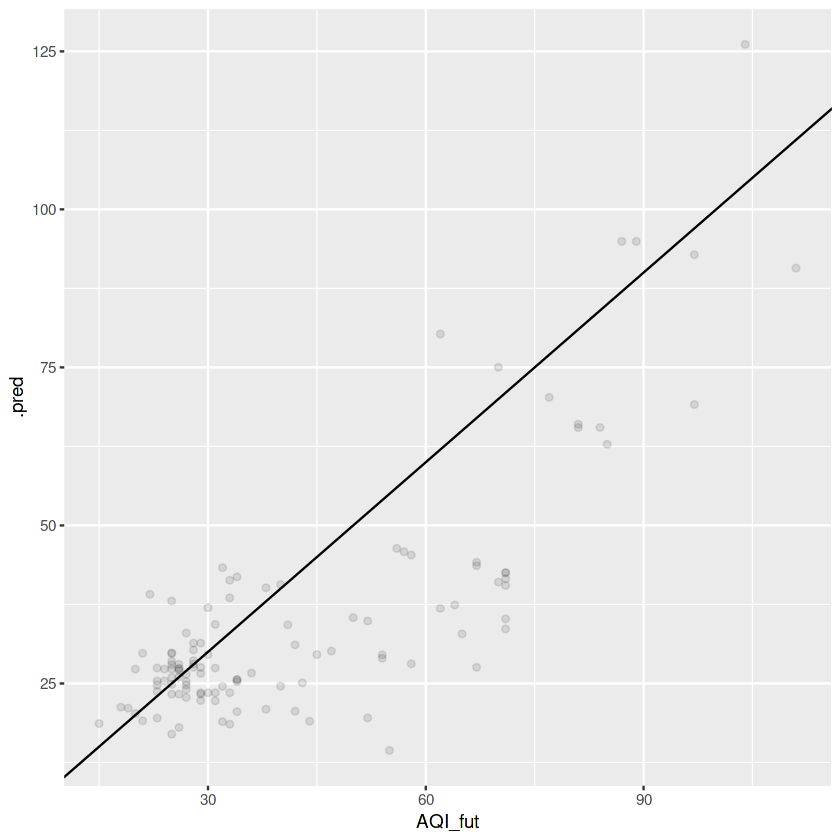

In [216]:
add_predictions(testing(aqi.split), fit.lm) %>% unnest(cols=c(pred)) %>% 
    ggplot(aes(x=AQI_fut, y=.pred)) + geom_point(alpha=.1) + geom_abline(intercept=0, slope=1)

And the boosted regression trees:

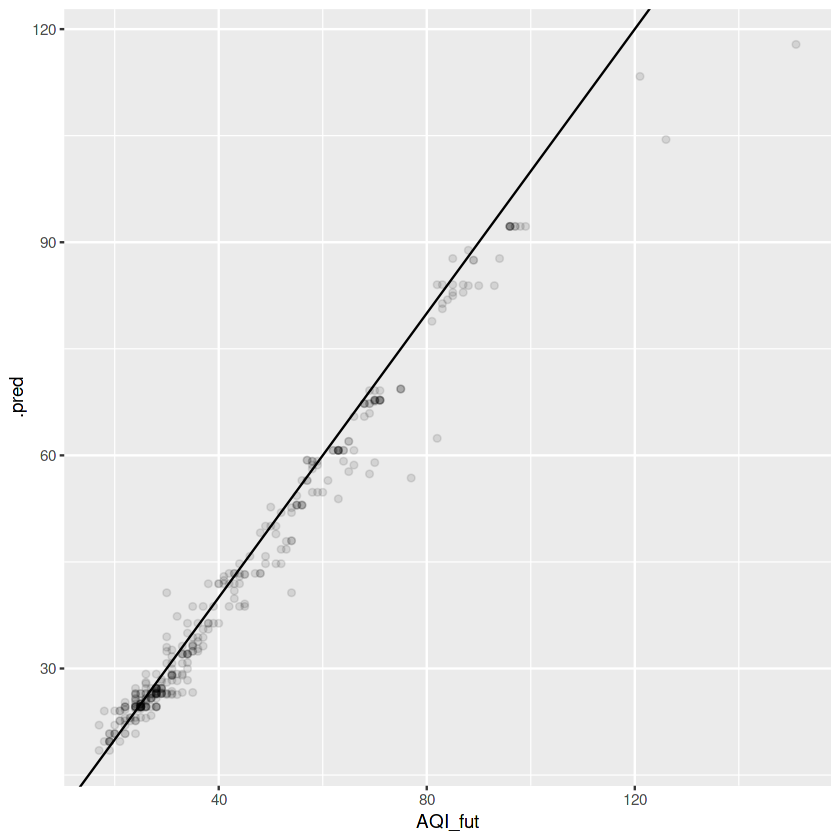

In [218]:
add_predictions(training(aqi.split), fit.bt) %>% unnest(cols=c(pred)) %>% 
    ggplot(aes(x=AQI_fut, y=.pred)) + geom_point(alpha=.1) + geom_abline(intercept=0, slope=1)

## Parameter tuning
Random forests have tuning parameters which can improve prediction performance, sometimes dramatically. 
The `tune` library can be used to automatune these parameters.

In [219]:
library(tune)
rf_tune <- rand_forest(trees = tune(), min_n=tune()) %>% 
  set_engine("ranger") %>% 
  set_mode("regression") %>% print

Random Forest Model Specification (regression)

Main Arguments:
  trees = tune()
  min_n = tune()

Computational engine: ranger 



If we try to run this model immediately, it won't work:

In [220]:
workflow() %>% add_model(rf_tune) %>% add_recipe(aqi.rec) %>% fit(training(aqi.split)) %>% print

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'print': Error: Invalid value for num.trees.


We will use brute force to tune the two parameters, `trees` and `min_n`:

In [221]:
tree_grid <- grid_regular(min_n(), trees(), levels = 3) %>% print

# A tibble: 9 × 2
  min_n trees
  <int> <int>
1     2     1
2    21     1
3    40     1
4     2  1000
5    21  1000
6    40  1000
7     2  2000
8    21  2000
9    40  2000


## Resampling
To do parameter tuning, we will use $k$-fold cross-validation:

In [222]:
library(rsample)
aqi.folds <- vfold_cv(training(aqi.split))
tree_wf <- workflow() %>% 
    add_model(rf_tune) %>% 
    add_recipe(aqi.rec)

# a2.tune <- tree_wf %>% tune_grid(resamples=a2.folds, grid=tree_grid)   # slooowwww

## Parallelization
Grid search hyperparameter tuning is sloooowwww--but also embarassingly parallel.

In [227]:
library(doFuture)
library(parallel)
all_cores <- parallel::detectCores(logical = FALSE)

library(doFuture)
registerDoFuture()
cl <- makeCluster(all_cores)
plan(cluster, workers = cl)

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when




In [238]:
aqi.tune <- tree_wf %>% tune_grid(resamples=aqi.folds, grid=tree_grid)  # fast

The best performing predictions are:

In [239]:
show_best(aqi.tune, metric="rmse")

trees,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2000,2,rmse,standard,6.212290,10,0.8016086,Preprocessor1_Model7
1000,2,rmse,standard,6.223077,10,0.8018902,Preprocessor1_Model4
1000,21,rmse,standard,7.968748,10,0.7331474,Preprocessor1_Model5
2000,21,rmse,standard,7.970815,10,0.7316430,Preprocessor1_Model8
1,2,rmse,standard,9.541870,10,1.1231501,Preprocessor1_Model1


In [240]:
best <- select_best(aqi.tune)
rf_best <- rand_forest(trees = best$trees, min_n=best$min_n) %>% 
  set_engine("ranger") %>% 
  set_mode("regression") %>% print

Warning message:
“No value of `metric` was given; metric 'rmse' will be used.”


Random Forest Model Specification (regression)

Main Arguments:
  trees = best$trees
  min_n = best$min_n

Computational engine: ranger 



In [241]:
best_rf <- workflow() %>% 
    add_model(rf_best) %>% 
    add_recipe(aqi.rec) %>% 
    fit(data=training(aqi.split)) 

test_pred <- best_rf %>% 
    add_predictions(testing(aqi.split), .) %>% 
    unnest(cols=pred)

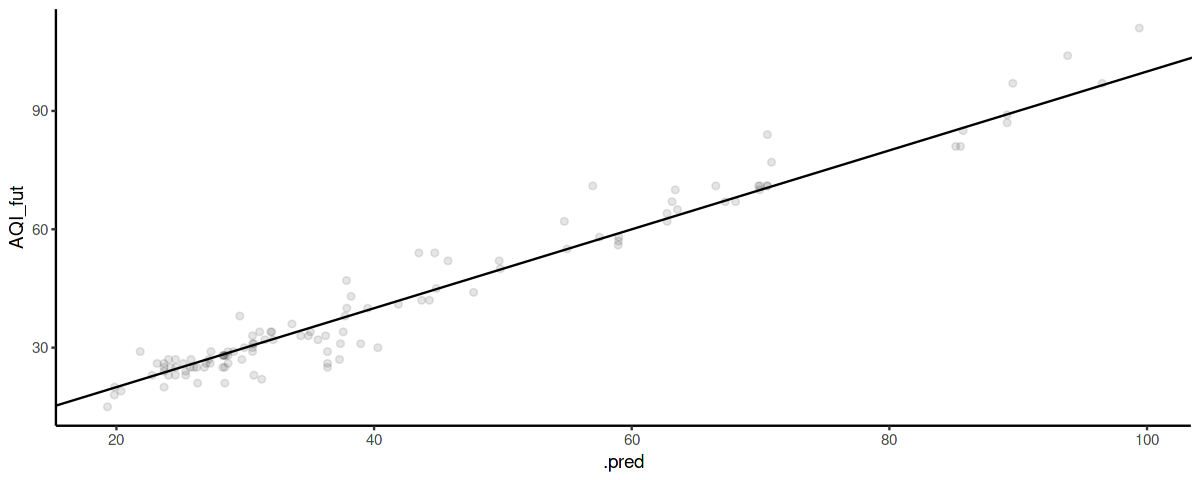

In [243]:
ggplot(test_pred) + geom_point(aes(x=.pred, y=AQI_fut), alpha=.1) + geom_abline(slope=1, intercept=0)